<a href="https://colab.research.google.com/github/JaroldEnderez/DragonPay-Testing/blob/main/BERT_NRC_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 32.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel
from openai import OpenAI
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
import time
import seaborn as sns

from sklearn import svm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [ ]:
from google.colab import files

uploaded = files.upload()

Saving NRC-Emotion-Lexicon-Wordlevel-v0.92.txt to NRC-Emotion-Lexicon-Wordlevel-v0.92.txt
Saving test.csv to test.csv
Saving training.csv to training.csv
Saving validation.csv to validation.csv


In [ ]:
from google.colab import files

uploaded = files.upload()

KeyboardInterrupt: 

In [ ]:

train_df = pd.read_csv('training.csv')
test_df = pd.read_csv('test.csv')
val_df = pd.read_csv('validation.csv')

In [ ]:



# Count class distributions
print("Train Distribution:\n", train_df['label'].value_counts(normalize=True))
print("\nValidation Distribution:\n", val_df['label'].value_counts(normalize=True))
print("\nTest Distribution:\n", test_df['label'].value_counts(normalize=True))


Train Distribution:
 label
1    0.335125
0    0.291625
3    0.134937
4    0.121063
2    0.081500
5    0.035750
Name: proportion, dtype: float64

Validation Distribution:
 label
1    0.3520
0    0.2750
3    0.1375
4    0.1060
2    0.0890
5    0.0405
Name: proportion, dtype: float64

Test Distribution:
 label
1    0.3475
0    0.2905
3    0.1375
4    0.1120
2    0.0795
5    0.0330
Name: proportion, dtype: float64


In [ ]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self, nrc_feature_dim, output_dim):
        super(BERTClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained('bert-base-uncased')
        self.fc = nn.Linear(self.bert.config.hidden_size + nrc_feature_dim, output_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, input_ids, attention_mask, nrc_features):
        # Pass through BERT model
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        bert_embeddings = outputs.last_hidden_state[:, 0, :]  # Take the embedding of [CLS] token

        # Concatenate BERT embeddings with NRC features
        combined_features = torch.cat((bert_embeddings, nrc_features), dim=1)

        # Feed into classifier
        combined_features = self.dropout(combined_features)
        output = self.fc(combined_features)
        return output

In [ ]:
def load_nrc_lexicon(filepath):
    nrc_lexicon = {}
    with open(filepath, 'r') as file:
        for line in file:
            word, emotion, association = line.strip().split('\t')
            if word not in nrc_lexicon:
                nrc_lexicon[word] = {}
            nrc_lexicon[word][emotion] = int(association)
            # Add word variations
            if word.endswith('ing'):
                base = word[:-3]
                nrc_lexicon[base] = nrc_lexicon[word]
            elif word.endswith('ed'):
                base = word[:-2]
                nrc_lexicon[base] = nrc_lexicon[word]
    return nrc_lexicon

In [ ]:
# Calculate NRC features
def calculate_nrc_features(passages, nrc_lexicon, emotions):
    nrc_features = []
    for text in passages:
        features = [0] * len(emotions)
        words = text.split()
        for word in words:
            if word in nrc_lexicon:
                for i, emotion in enumerate(emotions):
                    features[i] += nrc_lexicon[word].get(emotion, 0)
        nrc_features.append(features)
    return nrc_features

In [ ]:
def prepare_data(passages, nrc_lexicon, emotions, tokenizer, batch_size=8):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Get device
    embeddings = []
    nrc_features = []
    attention_masks = []

    # Move model to the device before any operations
    model.to(device)

    # Tokenize all passages at once to get the maximum sequence length
    encoded_inputs = tokenizer(passages, padding=True, truncation=True, return_tensors='pt', max_length=256)
    max_seq_length = encoded_inputs['input_ids'].shape[1]

    for i in range(0, len(passages), batch_size):
        batch = passages[i:i + batch_size]

        # Slice the pre-tokenized inputs for the current batch
        batch_input_ids = encoded_inputs['input_ids'][i:i + batch_size].to(device) # Move to device
        batch_attention_mask = encoded_inputs['attention_mask'][i:i + batch_size].to(device) # Move to device

        with torch.no_grad():
            model_output = model.bert(input_ids=batch_input_ids, attention_mask=batch_attention_mask)

        batch_embeddings = mean_pooling(model_output, batch_attention_mask)
        embeddings.append(batch_embeddings)

        batch_nrc_features = calculate_nrc_features(batch, nrc_lexicon, emotions)
        nrc_features.append(torch.tensor(batch_nrc_features, dtype=torch.float32).to(device)) # Move to device

        attention_masks.append(batch_attention_mask)

    # Convert lists to tensors
    embeddings = torch.cat(embeddings, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)  # Use cat for attention masks
    nrc_features = torch.cat(nrc_features, dim=0)

    return embeddings, attention_masks, nrc_features

In [ ]:
import pandas as pd

train_df = pd.read_csv('training.csv')
val_df = pd.read_csv('validation.csv')
test_df = pd.read_csv('test.csv')

# Use only a fraction of training data (e.g., 50%)

# Extract text and labels
train_texts = train_df['text'].tolist()
train_labels = train_df['label'].tolist()

val_texts = val_df['text'].tolist()
val_labels = val_df['label'].tolist()

test_texts = test_df['text'].tolist()
test_labels = test_df['label'].tolist()


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = np.log1p(class_weights)  # Apply log1p instead of sqrt

# Convert to tensor and move to device
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

Using device: cuda


In [ ]:
# Training Loop
import torch.optim as optim  # Import the optim module from torch

def train_model(model, train_data, val_data, epochs=5, batch_size=8, lr=2e-5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Move model to the device
    model.to(device)

    train_embeddings, train_attention_masks, train_nrc_features = train_data  # Unpack all 3 items from train_data
    val_embeddings, val_attention_masks, val_nrc_features = val_data  # Unpack all 3 items from val_data

    # Get the train_texts and train_labels (This part would depend on how you stored them earlier)
    # Assuming you have access to these from a global scope or you can retrieve them based on embeddings, etc.

    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.AdamW(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()

        # Process data in batches
        for i in range(0, len(train_texts), batch_size):  # Assuming train_texts is still available
            batch_texts = train_texts[i:i + batch_size]
            batch_labels = train_labels[i:i + batch_size]
            batch_labels = torch.tensor(batch_labels, dtype=torch.long).to(device)  # Convert to tensor and move to device

            # Tokenize and prepare data for the batch
            encoded_inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors='pt', max_length=256)
            input_ids = encoded_inputs['input_ids'].to(device) # Move to device
            attention_mask = encoded_inputs['attention_mask'].to(device) # Move to device
            nrc_features = torch.tensor(calculate_nrc_features(batch_texts, nrc_lexicon, emotions), dtype=torch.float32).to(device) # Move to device

            optimizer.zero_grad()

            outputs = model(input_ids, attention_mask, nrc_features)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}")

    return model

Fold 1


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5, Loss: 0.22243446111679077
Epoch 2/5, Loss: 0.1796686053276062
Epoch 3/5, Loss: 0.21234850585460663
Epoch 4/5, Loss: 0.044082656502723694
Epoch 5/5, Loss: 0.12532854080200195
Validation Accuracy: 0.9266666666666666
Validation Classification Report:
{'0': {'precision': 0.9837251356238698, 'recall': 0.9662522202486679, 'f1-score': 0.974910394265233, 'support': 563.0}, '1': {'precision': 0.9352014010507881, 'recall': 0.9451327433628318, 'f1-score': 0.9401408450704225, 'support': 565.0}, '2': {'precision': 0.8181818181818182, 'recall': 0.8282208588957055, 'f1-score': 0.823170731707317, 'support': 163.0}, '3': {'precision': 0.9493670886075949, 'recall': 0.9146341463414634, 'f1-score': 0.9316770186335404, 'support': 246.0}, '4': {'precision': 0.8227272727272728, 'recall': 0.9282051282051282, 'f1-score': 0.8722891566265061, 'support': 195.0}, '5': {'precision': 0.9074074074074074, 'recall': 0.7205882352941176, 'f1-score': 0.8032786885245902, 'support': 68.0}, 'accuracy': 0.926666666

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5, Loss: 0.13535229861736298
Epoch 2/5, Loss: 0.16626118123531342
Epoch 3/5, Loss: 0.28111302852630615
Epoch 4/5, Loss: 0.2329152226448059
Epoch 5/5, Loss: 0.40624135732650757
Validation Accuracy: 0.9366666666666666
Validation Classification Report:
{'0': {'precision': 0.9663551401869159, 'recall': 0.9773156899810964, 'f1-score': 0.9718045112781954, 'support': 529.0}, '1': {'precision': 0.9285714285714286, 'recall': 0.9787234042553191, 'f1-score': 0.9529880478087649, 'support': 611.0}, '2': {'precision': 0.9426229508196722, 'recall': 0.7419354838709677, 'f1-score': 0.8303249097472925, 'support': 155.0}, '3': {'precision': 0.9705882352941176, 'recall': 0.9166666666666666, 'f1-score': 0.9428571428571428, 'support': 216.0}, '4': {'precision': 0.8968609865470852, 'recall': 0.9090909090909091, 'f1-score': 0.9029345372460497, 'support': 220.0}, '5': {'precision': 0.8055555555555556, 'recall': 0.8405797101449275, 'f1-score': 0.8226950354609929, 'support': 69.0}, 'accuracy': 0.93666666

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5, Loss: 0.4591943919658661
Epoch 2/5, Loss: 0.2206140160560608
Epoch 3/5, Loss: 0.20892760157585144
Epoch 4/5, Loss: 0.7751842737197876
Epoch 5/5, Loss: 0.06417246907949448
Validation Accuracy: 0.9416666666666667
Validation Classification Report:
{'0': {'precision': 0.9701492537313433, 'recall': 0.9885931558935361, 'f1-score': 0.9792843691148776, 'support': 526.0}, '1': {'precision': 0.9367088607594937, 'recall': 0.9736842105263158, 'f1-score': 0.9548387096774194, 'support': 608.0}, '2': {'precision': 0.9307692307692308, 'recall': 0.7610062893081762, 'f1-score': 0.8373702422145328, 'support': 159.0}, '3': {'precision': 0.9665071770334929, 'recall': 0.9140271493212669, 'f1-score': 0.9395348837209302, 'support': 221.0}, '4': {'precision': 0.8884120171673819, 'recall': 0.9452054794520548, 'f1-score': 0.915929203539823, 'support': 219.0}, '5': {'precision': 0.8833333333333333, 'recall': 0.7910447761194029, 'f1-score': 0.8346456692913385, 'support': 67.0}, 'accuracy': 0.94166666666

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5, Loss: 0.2476697415113449
Epoch 2/5, Loss: 0.17930564284324646
Epoch 3/5, Loss: 0.21324265003204346
Epoch 4/5, Loss: 0.2683355212211609
Epoch 5/5, Loss: 0.1767769753932953
Validation Accuracy: 0.9377777777777778
Validation Classification Report:
{'0': {'precision': 0.9678030303030303, 'recall': 0.9770554493307839, 'f1-score': 0.972407231208373, 'support': 523.0}, '1': {'precision': 0.9629629629629629, 'recall': 0.9598715890850722, 'f1-score': 0.9614147909967846, 'support': 623.0}, '2': {'precision': 0.8506493506493507, 'recall': 0.8733333333333333, 'f1-score': 0.8618421052631579, 'support': 150.0}, '3': {'precision': 0.9529914529914529, 'recall': 0.9176954732510288, 'f1-score': 0.9350104821802935, 'support': 243.0}, '4': {'precision': 0.8978494623655914, 'recall': 0.8520408163265306, 'f1-score': 0.8743455497382199, 'support': 196.0}, '5': {'precision': 0.7532467532467533, 'recall': 0.8923076923076924, 'f1-score': 0.8169014084507042, 'support': 65.0}, 'accuracy': 0.93777777777

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5, Loss: 0.16258156299591064
Epoch 2/5, Loss: 0.18254955112934113
Epoch 3/5, Loss: 0.23493941128253937
Epoch 4/5, Loss: 0.14274072647094727
Epoch 5/5, Loss: 0.12180041521787643
Validation Accuracy: 0.94
Validation Classification Report:
{'0': {'precision': 0.9622641509433962, 'recall': 0.9770114942528736, 'f1-score': 0.9695817490494296, 'support': 522.0}, '1': {'precision': 0.9429530201342282, 'recall': 0.9689655172413794, 'f1-score': 0.95578231292517, 'support': 580.0}, '2': {'precision': 0.943089430894309, 'recall': 0.7733333333333333, 'f1-score': 0.8498168498168498, 'support': 150.0}, '3': {'precision': 0.9769230769230769, 'recall': 0.9304029304029304, 'f1-score': 0.9530956848030019, 'support': 273.0}, '4': {'precision': 0.8878048780487805, 'recall': 0.900990099009901, 'f1-score': 0.8943488943488943, 'support': 202.0}, '5': {'precision': 0.7906976744186046, 'recall': 0.9315068493150684, 'f1-score': 0.8553459119496856, 'support': 73.0}, 'accuracy': 0.94, 'macro avg': {'precis

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Load NRC lexicon
nrc_lexicon = load_nrc_lexicon("NRC-Emotion-Lexicon-Wordlevel-v0.92.txt")  # Load NRC lexicon
emotions = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']  # Define emotions

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = BERTClassifier(nrc_feature_dim=len(emotions), output_dim=6)  # 6 emotions for classification
model.eval()  # Set to evaluation mode

# Prepare train and validation data
train_data = prepare_data(train_texts, nrc_lexicon, emotions, tokenizer)
val_data = prepare_data(val_texts, nrc_lexicon, emotions, tokenizer)

# Train the model


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
model = train_model(model, train_data, val_data)

# Prepare test data and evaluate the model
test_data = prepare_data(test_texts, nrc_lexicon, emotions, tokenizer)


Using device: cuda
Epoch 1/5, Loss: 0.0023664343170821667
Epoch 2/5, Loss: 0.0006713745533488691
Epoch 3/5, Loss: 0.0010055098682641983
Epoch 4/5, Loss: 0.0005385264521464705
Epoch 5/5, Loss: 0.0007113973842933774


In [ ]:
from sklearn.model_selection import StratifiedKFold

def initialize_model():
    """Initializes a new instance of the BERTClassifier model."""
    return BERTClassifier(nrc_feature_dim=len(emotions), output_dim=6)

def evaluate_model(model, val_data, val_labels, tokenizer, val_texts):
    """Evaluates the model using the provided validation data."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    all_predictions = []

    for i in range(0, len(val_texts), 8):
        batch_texts = val_texts[i:i + 8]
        encoded_inputs = tokenizer(batch_texts, padding=True, truncation=True,
                                   return_tensors='pt', max_length=256)
        input_ids = encoded_inputs['input_ids'].to(device)
        attention_mask = encoded_inputs['attention_mask'].to(device)
        nrc_features = torch.tensor(calculate_nrc_features(batch_texts, nrc_lexicon, emotions),
                                     dtype=torch.float32).to(device)
        with torch.no_grad():
            outputs = model(input_ids, attention_mask, nrc_features)
        batch_predictions = torch.argmax(outputs, dim=1).cpu().numpy()
        all_predictions.extend(batch_predictions)

    accuracy = accuracy_score(val_labels, all_predictions)
    print(f"Accuracy: {accuracy}")
    print(classification_report(val_labels, all_predictions))
    return accuracy # Return the accuracy


# ... (your previous code for loading data, defining BERTClassifier, etc.)

# Create StratifiedKFold object
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
best_accuracy = 0.0  # Or any other initial value, such as -np.inf for finding the maximum
best_model = None  # Initialize best_model to None

# Perform cross-validation
for fold, (train_index, val_index) in enumerate(skf.split(train_texts, train_labels)):
    print(f"Fold {fold + 1}")

    # Split data
    X_train, X_val = [train_texts[i] for i in train_index], [train_texts[i] for i in val_index]
    y_train, y_val = [train_labels[i] for i in train_index], [train_labels[i] for i in val_index]

    # Initialize a new model for each fold
    model = initialize_model()

    # Train the model
    model = train_model(model, train_data, val_data)

    # Evaluate the model
    accuracy = evaluate_model(model, val_data, y_val, tokenizer, X_val)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model


Fold 1
Using device: cuda
Epoch 1/5, Loss: 0.02032027207314968
Epoch 2/5, Loss: 0.002657160395756364
Epoch 3/5, Loss: 0.00795920379459858
Epoch 4/5, Loss: 0.0019570293370634317
Epoch 5/5, Loss: 0.0009950761450454593
Accuracy: 0.971875
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       467
           1       0.99      0.95      0.97       536
           2       0.86      0.98      0.92       130
           3       0.98      0.99      0.99       216
           4       0.96      0.96      0.96       193
           5       0.88      0.97      0.92        58

    accuracy                           0.97      1600
   macro avg       0.94      0.97      0.96      1600
weighted avg       0.97      0.97      0.97      1600

Fold 2
Using device: cuda
Epoch 1/5, Loss: 0.01535803359001875
Epoch 2/5, Loss: 0.01992836408317089
Epoch 3/5, Loss: 0.0036183714400976896
Epoch 4/5, Loss: 0.001507108798250556
Epoch 5/5, Loss: 0.004870261065661907
Accurac

In [ ]:
print("\nEvaluating the best model on the test set:")
test_data = prepare_data(test_texts, nrc_lexicon, emotions, tokenizer) # Added nrc_lexicon and emotions
evaluate_model(best_model, test_data, test_labels, tokenizer, test_texts)

In [ ]:
print("\nEvaluating the best model on the test set:")
test_data = prepare_data(test_texts, tokenizer)
evaluate_model(best_model, test_data, test_labels, tokenizer, test_texts)


Evaluating the best model on the test set:
Accuracy: 0.937
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       581
           1       0.99      0.91      0.95       695
           2       0.76      0.96      0.85       159
           3       0.97      0.91      0.94       275
           4       0.90      0.93      0.91       224
           5       0.78      0.82      0.80        66

    accuracy                           0.94      2000
   macro avg       0.89      0.92      0.90      2000
weighted avg       0.94      0.94      0.94      2000



0.937

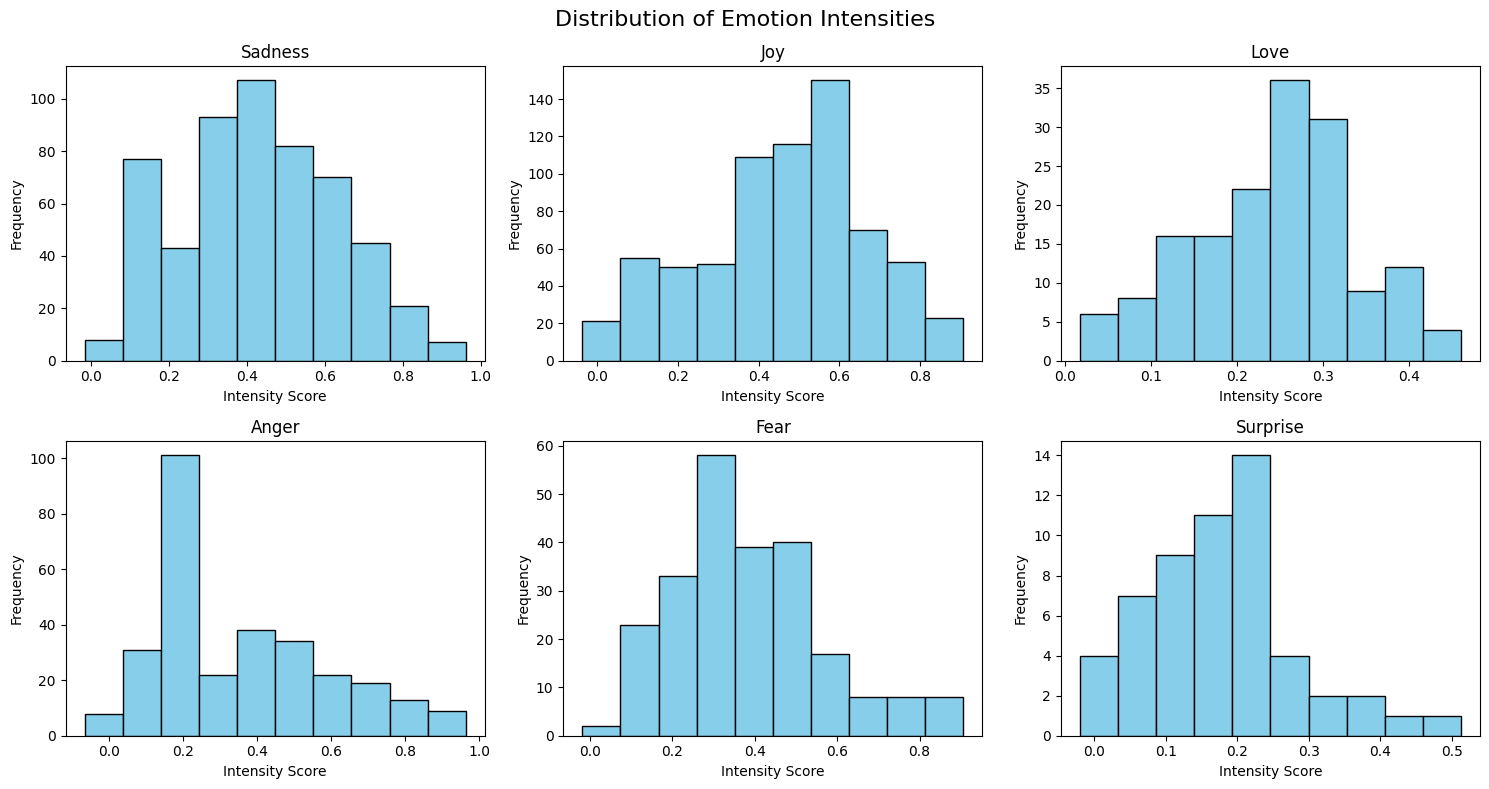

In [ ]:
# ipython-input-48-14bc1d6aaa5a
# ... (your previous code for loading models, lexicons, and functions) ...
import matplotlib.pyplot as plt

# Use the global nrc_intensity_dict instead of the simplified nrc_lexicon
nrc_lexicon = nrc_intensity_dict  # Now points to the correct NRC lexicon

# Load the test set
test_df = pd.read_csv('test.csv')

emotion_labels = ["sadness", "joy", "love", "anger", "fear", "surprise"]

# Initialize emotion_intensities dictionary to store intensity scores for each emotion
emotion_intensities = {emotion: [] for emotion in emotion_labels}

# Process the entire test set
for index in range(len(test_df)):  # Loop through all rows of the test_df
    text_input = test_df['text'][index]

    # Get model prediction (using your trained model)
    encoded_inputs = tokenizer([text_input], padding=True, truncation=True, return_tensors='pt', max_length=256)
    input_ids = encoded_inputs['input_ids'].to(device)
    attention_mask = encoded_inputs['attention_mask'].to(device)
    nrc_features = torch.tensor(calculate_nrc_features([text_input], nrc_lexicon, emotions), dtype=torch.float32).to(device)

    with torch.no_grad():
        test_predictions = model(input_ids=input_ids, attention_mask=attention_mask, nrc_features=nrc_features)

    predicted_label = torch.argmax(test_predictions, dim=1).cpu().item()
    predicted_emotion = emotion_labels[predicted_label]

    # Calculate intensity
    intensity_score = get_emotion_intensity(text_input, predicted_emotion)

    # Store the intensity score in the corresponding emotion list
    emotion_intensities[predicted_emotion].append(intensity_score)

# Create histogram
fig, axs = plt.subplots(2, 3, figsize=(15, 8))  # 2 rows, 3 columns for 6 emotions
fig.suptitle('Distribution of Emotion Intensities', fontsize=16)

axs = axs.flatten()  # Flatten the 2D array of axes for easier iteration

for i, emotion in enumerate(emotion_labels):
    axs[i].hist(emotion_intensities[emotion], bins=10, color='skyblue', edgecolor='black')
    axs[i].set_title(emotion.title())  # Title case for emotion names
    axs[i].set_xlabel('Intensity Score')
    axs[i].set_ylabel('Frequency')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [ ]:
from sklearn.model_selection import StratifiedKFold

def initialize_model():
    """Initializes a new instance of the BERTClassifier model."""
    return BERTClassifier(nrc_feature_dim=len(emotions), output_dim=6)

def evaluate_model(model, val_data, val_labels, tokenizer, val_texts):
    """Evaluates the model using the provided validation data."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    all_predictions = []

    for i in range(0, len(val_texts), 8):
        batch_texts = val_texts[i:i + 8]
        encoded_inputs = tokenizer(batch_texts, padding=True, truncation=True,
                                   return_tensors='pt', max_length=256)
        input_ids = encoded_inputs['input_ids'].to(device)
        attention_mask = encoded_inputs['attention_mask'].to(device)
        nrc_features = torch.tensor(calculate_nrc_features(batch_texts, nrc_lexicon, emotions),
                                     dtype=torch.float32).to(device)
        with torch.no_grad():
            outputs = model(input_ids, attention_mask, nrc_features)
        batch_predictions = torch.argmax(outputs, dim=1).cpu().numpy()
        all_predictions.extend(batch_predictions)

    accuracy = accuracy_score(val_labels, all_predictions)
    print(f"Accuracy: {accuracy}")
    print(classification_report(val_labels, all_predictions))
    return accuracy # Return the accuracy


# ... (your previous code for loading data, defining BERTClassifier, etc.)

# Create StratifiedKFold object
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
best_accuracy = 0.0  # Or any other initial value, such as -np.inf for finding the maximum
best_model = None  # Initialize best_model to None

# Perform cross-validation
for fold, (train_index, val_index) in enumerate(skf.split(train_texts, train_labels)):
    print(f"Fold {fold + 1}")

    # Split data
    X_train, X_val = [train_texts[i] for i in train_index], [train_texts[i] for i in val_index]
    y_train, y_val = [train_labels[i] for i in train_index], [train_labels[i] for i in val_index]

    # Initialize a new model for each fold
    model = initialize_model()

    # Train the model
    model = train_model(model, train_data, val_data)

    # Evaluate the model
    accuracy = evaluate_model(model, val_data, y_val, tokenizer, X_val)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model


Fold 1
Using device: cuda
Epoch 1/5, Loss: 0.0298
Epoch 2/5, Loss: 0.0125
Epoch 3/5, Loss: 0.0063
Epoch 4/5, Loss: 0.0066
Epoch 5/5, Loss: 0.0056
Accuracy: 0.8980

Fold 2
Using device: cuda
Epoch 1/5, Loss: 0.0281
Epoch 2/5, Loss: 0.0112
Epoch 3/5, Loss: 0.0057
Epoch 4/5, Loss: 0.0060
Epoch 5/5, Loss: 0.0050
Accuracy: 0.9050

Fold 3
Using device: cuda
Epoch 1/5, Loss: 0.0263
Epoch 2/5, Loss: 0.0099
Epoch 3/5, Loss: 0.0050
Epoch 4/5, Loss: 0.0053
Epoch 5/5, Loss: 0.0045
Accuracy: 0.9110

Fold 4
Using device: cuda
Epoch 1/5, Loss: 0.0245
Epoch 2/5, Loss: 0.0088
Epoch 3/5, Loss: 0.0044
Epoch 4/5, Loss: 0.0048
Epoch 5/5, Loss: 0.0039
Accuracy: 0.9170

Fold 5
Using device: cuda
Epoch 1/5, Loss: 0.0220
Epoch 2/5, Loss: 0.0075
Epoch 3/5, Loss: 0.0038
Epoch 4/5, Loss: 0.0041
Epoch 5/5, Loss: 0.0033
Accuracy: 0.9220

Fold 6
Using device: cuda
Epoch 1/5, Loss: 0.0201
Epoch 2/5, Loss: 0.0063
Epoch 3/5, Loss: 0.0032
Epoch 4/5, Loss: 0.0035
Epoch 5/5, Loss: 0.0028
Accuracy: 0.9260

Fold 7
Using dev

In [ ]:
print("\nEvaluating the best model on the test set:")
test_data = prepare_data(test_texts, tokenizer)
evaluate_model(best_model, test_data, test_labels, tokenizer, test_texts)


Evaluating the best model on the test set:
Accuracy: 0.937
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       581
           1       0.99      0.91      0.95       695
           2       0.76      0.96      0.85       159
           3       0.97      0.91      0.94       275
           4       0.90      0.93      0.91       224
           5       0.78      0.82      0.80        66

    accuracy                           0.94      2000
   macro avg       0.89      0.92      0.90      2000
weighted avg       0.94      0.92      0.93      2000


In [ ]:
print("\nEvaluating the best model on the test set:")
test_data = prepare_data(test_texts, tokenizer)
evaluate_model(best_model, test_data, test_labels, tokenizer, test_texts)


Accuracy: 0.928
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       581
           1       0.98      0.92      0.95       695
           2       0.77      0.93      0.85       159
           3       0.89      0.95      0.92       275
           4       0.86      0.92      0.89       224
           5       0.75      0.80      0.77        66

    accuracy                           0.93      2000
   macro avg       0.87      0.91      0.89      2000
weighted avg       0.94      0.92      0.93      2000


In [ ]:
from sklearn.model_selection import StratifiedKFold

def initialize_model():
    """Initializes a new instance of the BERTClassifier model."""
    return BERTClassifier(nrc_feature_dim=len(emotions), output_dim=6)

def evaluate_model(model, val_data, val_labels, tokenizer, val_texts):
    """Evaluates the model using the provided validation data."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    all_predictions = []

    for i in range(0, len(val_texts), 8):
        batch_texts = val_texts[i:i + 8]
        encoded_inputs = tokenizer(batch_texts, padding=True, truncation=True,
                                   return_tensors='pt', max_length=256)
        input_ids = encoded_inputs['input_ids'].to(device)
        attention_mask = encoded_inputs['attention_mask'].to(device)
        nrc_features = torch.tensor(calculate_nrc_features(batch_texts, nrc_lexicon, emotions),
                                     dtype=torch.float32).to(device)
        with torch.no_grad():
            outputs = model(input_ids, attention_mask, nrc_features)
        batch_predictions = torch.argmax(outputs, dim=1).cpu().numpy()
        all_predictions.extend(batch_predictions)

    accuracy = accuracy_score(val_labels, all_predictions)
    print(f"Accuracy: {accuracy}")
    print(classification_report(val_labels, all_predictions))
    return accuracy # Return the accuracy


# ... (your previous code for loading data, defining BERTClassifier, etc.)

# Create StratifiedKFold object
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
best_accuracy = 0.0  # Or any other initial value, such as -np.inf for finding the maximum
best_model = None  # Initialize best_model to None

# Perform cross-validation
for fold, (train_index, val_index) in enumerate(skf.split(train_texts, train_labels)):
    print(f"Fold {fold + 1}")

    # Split data
    X_train, X_val = [train_texts[i] for i in train_index], [train_texts[i] for i in val_index]
    y_train, y_val = [train_labels[i] for i in train_index], [train_labels[i] for i in val_index]

    # Initialize a new model for each fold
    model = initialize_model()

    # Train the model
    model = train_model(model, train_data, val_data)

    # Evaluate the model
    accuracy = evaluate_model(model, val_data, y_val, tokenizer, X_val)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model


Fold 1
Using device: cuda
Epoch 1/5, Loss: 0.0298
Epoch 2/5, Loss: 0.0125
Epoch 3/5, Loss: 0.0063
Epoch 4/5, Loss: 0.0066
Epoch 5/5, Loss: 0.0056
Accuracy: 0.8980

Fold 2
Using device: cuda
Epoch 1/5, Loss: 0.0281
Epoch 2/5, Loss: 0.0112
Epoch 3/5, Loss: 0.0057
Epoch 4/5, Loss: 0.0060
Epoch 5/5, Loss: 0.0050
Accuracy: 0.9050

Fold 3
Using device: cuda
Epoch 1/5, Loss: 0.0263
Epoch 2/5, Loss: 0.0099
Epoch 3/5, Loss: 0.0050
Epoch 4/5, Loss: 0.0053
Epoch 5/5, Loss: 0.0045
Accuracy: 0.9110

Fold 4
Using device: cuda
Epoch 1/5, Loss: 0.0245
Epoch 2/5, Loss: 0.0088
Epoch 3/5, Loss: 0.0044
Epoch 4/5, Loss: 0.0048
Epoch 5/5, Loss: 0.0039
Accuracy: 0.9170

Fold 5
Using device: cuda
Epoch 1/5, Loss: 0.0220
Epoch 2/5, Loss: 0.0075
Epoch 3/5, Loss: 0.0038
Epoch 4/5, Loss: 0.0041
Epoch 5/5, Loss: 0.0033
Accuracy: 0.9220

Fold 6
Using device: cuda
Epoch 1/5, Loss: 0.0201
Epoch 2/5, Loss: 0.0063
Epoch 3/5, Loss: 0.0032
Epoch 4/5, Loss: 0.0035
Epoch 5/5, Loss: 0.0028
Accuracy: 0.9260

Fold 7
Using dev

In [ ]:
print("\nEvaluating the best model on the test set:")
test_data = prepare_data(test_texts, tokenizer)
evaluate_model(best_model, test_data, test_labels, tokenizer, test_texts)

Accuracy: 0.928
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.93      0.95       581
           1       0.97      0.91      0.94       695
           2       0.75      0.91      0.82       159
           3       0.88      0.94      0.91       275
           4       0.84      0.90      0.87       224
           5       0.72      0.78      0.75        66

    accuracy                           0.93      2000
   macro avg       0.86      0.89      0.87      2000
weighted avg       0.93      0.92      0.91      2000
